In [29]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from sklearn.svm import SVR, OneClassSVM, NuSVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore, t

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.neighbors import LocalOutlierFactor


from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [30]:
#function returns SOC value
def get_soc(kernel,sp,p):
    if kernel=='rbf':
        return sp*(3*p+3)
    if kernel == 'linear':
        return sp*(2*p+1)
    return sp*(2*p+4)

#custom metric based on SOC
def soc_metric(model,*args,**kwargs):
  X,y=args
  return -get_soc(model.kernel,len(model.support_vectors_),X.shape[1])

In the description of Auto MPG dataset, existence of missing values is noted, we will simply remove rows with missing values in any column






In [31]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
columns = ['mpg','cylinders','displacement','horsepower','weight','acceleration','year','origin','name']
df = pd.read_csv(uploaded,delim_whitespace=True,names=columns)

#drop name column
df.drop(columns=['name'],inplace=True)

columns = ['cylinders','displacement','horsepower','weight','acceleration','year','origin']
print(df.shape)
df.dtypes

(398, 8)


mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
year              int64
origin            int64
dtype: object

type of horsepower is an object, need to check values

In [32]:
df.horsepower.unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

In [33]:
#remove rows with missing horsepower value
df=df[df['horsepower']!='?']

#convert horspower variable type from object to float
df['horsepower']=df['horsepower'].astype('float')

In [34]:
#check if there are any missing values
df.isnull().any()

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
year            False
origin          False
dtype: bool

In [35]:
#scale independent variables
df[columns]=StandardScaler().fit_transform(df[columns])

#apply z-score outlier treatment
z = np.abs(zscore(df['origin']))
df = df[ (z < 3) ]

z = np.abs(zscore(df['cylinders']))
df = df[ (z < 3) ]

z = np.abs(zscore(df['displacement']))
df = df[ (z < 3) ]

z = np.abs(zscore(df['horsepower']))
df = df[ (z < 3) ]

print(df.shape)
df.head()
(z < 3).shape

(387, 8)


(392,)

In [36]:
X_orig=df[columns]
y=df['mpg']
print(X_orig.shape)
pd.DataFrame(data=[X_orig.skew(),X_orig.kurtosis()],index=['skewness','kurtosis'])

(387, 7)


,cylinders,displacement,horsepower,weight,acceleration,year,origin
skewness,0.542020,0.680172,0.972767,0.533444,0.357604,0.006229,0.895431
kurtosis,-1.349136,-0.859466,0.330579,-0.777661,0.494826,-1.161029,-0.878073


In [37]:
outliers = LocalOutlierFactor(n_neighbors=20).fit_predict(X_orig)
target_out = LocalOutlierFactor(n_neighbors=20).fit_predict(y.values.reshape(-1,1))

outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t

X_orig,y=X_orig[outliers],y[outliers]
X_orig.shape

(367, 7)

In [38]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_orig.values, i) for i in range(X_orig.shape[1])]
vif["features"] = pd.Index(X_orig.columns)
vif

,VIF Factor,features
0,11.595235,cylinders
1,25.220473,displacement
2,12.059962,horsepower
3,13.645880,weight
4,2.981343,acceleration
5,1.179812,year
6,1.778268,origin


Highest VIF>= 10 value is for displacement(25.1), remove displacement

In [39]:
# 'cylinders','displacement','horsepower','weight','acceleration','year','origin'
X = X_orig.drop(['displacement'],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = pd.Index(X.columns)
vif

,VIF Factor,features
0,6.063121,cylinders
1,11.637274,horsepower
2,10.785911,weight
3,2.947527,acceleration
4,1.166278,year
5,1.581089,origin


Highest VIF>=10 value is for horsepower(VIF=11.6), remove horsepower

In [40]:
# 'cylinders','displacement','horsepower','weight','acceleration','year','origin'
X = X.drop(['horsepower'],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = pd.Index(X.columns)
vif

,VIF Factor,features
0,5.983898,cylinders
1,5.322073,weight
2,1.386625,acceleration
3,1.108375,year
4,1.520909,origin


In [27]:
# 'cylinders','weight','acceleration','year','origin'
# X = X.drop(['cylinders'],axis=1)
# X.head()

# X = SelectKBest(f_regression, k=3).fit_transform(X, y)
# print(X[:10])
# X_orig.head()

[[ 1.48394702  0.62054034 -0.71664105]
 [ 1.48394702  0.84333403 -0.71664105]
 [ 1.48394702  0.54038176 -0.71664105]
 [ 1.48394702  0.53684535 -0.71664105]
 [ 1.48394702  0.5557062  -0.71664105]
 [ 1.48394702  1.60719812 -0.71664105]
 [ 1.48394702  1.02840604 -0.71664105]
 [ 1.48394702  0.69008969 -0.71664105]
 [ 1.48394702  0.74431461 -0.71664105]
 [ 1.48394702  0.92349261 -0.71664105]]


,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,1.483947,1.077290,0.664133,0.620540,-1.285258,-1.625315,-0.716641
1,1.483947,1.488732,1.574594,0.843334,-1.466724,-1.625315,-0.716641
2,1.483947,1.182542,1.184397,0.540382,-1.648189,-1.625315,-0.716641
3,1.483947,1.048584,1.184397,0.536845,-1.285258,-1.625315,-0.716641
4,1.483947,1.029447,0.924265,0.555706,-1.829655,-1.625315,-0.716641


In [41]:
k=X.shape[1]
acc_metric = 'neg_mean_squared_error'
acc_metric = 'neg_mean_absolute_error'
cv = KFold(n_splits=10, shuffle= True,random_state=100)
model_selected=None
minRMSE=np.inf
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])

try:
    X=X.to_numpy()
except:
    pass
try:
    y=y.to_numpy()
except:
    pass
X.shape

(367, 5)

In [42]:
model=LinearRegression()
mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MAE: ",mse,"STD: ",std)

MAE:  2.304721868255995 STD:  0.22894803789004067


Best Hyperparameters::
{'C': 695.1927961775606, 'gamma': 0.05455594781168517, 'kernel': 'rbf'}
# SV 348
SOC:  5568
MSE:  1.8304087320778009 STD:  0.17863479364253215


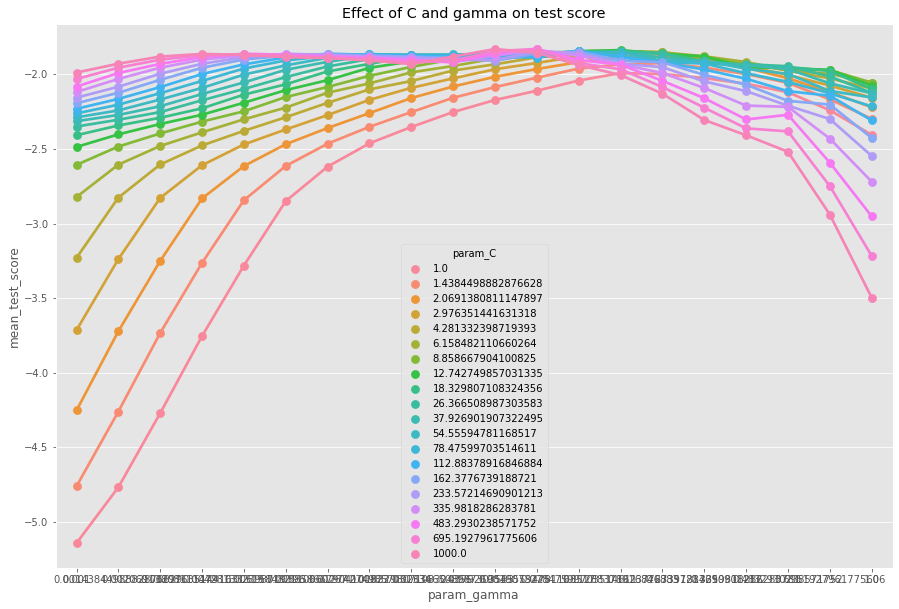

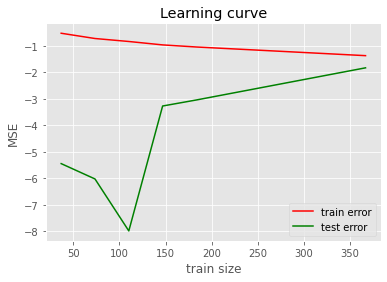

In [267]:
params = {'C':np.logspace(0,3,20),
          'gamma':np.logspace(-3,0,20),
          'kernel':['rbf',]}


gcv = GridSearchCV(SVR(),params,cv=cv,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("# SV",len(svr.support_vectors_))
print("SOC: ",len(svr.support_vectors_)*(3*k+3))


mse = cross_val_score(svr,X,y,cv=cv,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))

print("MSE: ",mse,"STD: ",std)



if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()



_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

In [247]:
minRMSE=1.830409
minRMSE,minRMSE*1.1

(1.830409, 2.0134499)

In [243]:

k=X.shape[1]

gammas = np.logspace(-3,0,20)

min_soc = 1000000
min_gamma=100000
min_c = 100000
socs = np.array([])
mses=np.array([])
colors=np.array([])
minErr=100000
for C in np.logspace(0,3,20):
    for gamma in gammas:
        model = SVR(C=C,gamma=gamma,kernel='rbf')
        model.fit(X,y)
        soc = len(model.support_vectors_)*(3*k+3)
        socs = np.append(socs,soc)
        mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)
        mse=np.abs(np.mean(mse))
        mses = np.append(mses,mse)
        if mse > minRMSE*1.1:
            colors=np.append(colors,'red')
        else:
            colors=np.append(colors,'green')
        if min_soc >= soc:
            min_soc = soc
            min_gamma = gamma
            min_c = C
            min_err=mse

min SOC:  4485  corresponding Error:  1.846479218296133
min C:  233.57214690901213  min gamma:  0.4832930238571752


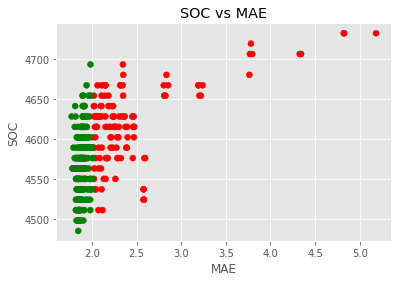

In [244]:
plt.title('SOC vs MAE')
plt.scatter(mses,socs,c=colors)
plt.xlabel('MAE')
plt.ylabel('SOC')
print('min SOC: ',min_soc,' corresponding Error: ',min_err)
print('min C: ',min_c,' min gamma: ',min_gamma)
plt.show()

In [123]:
4446/(3*k+1)

342.0

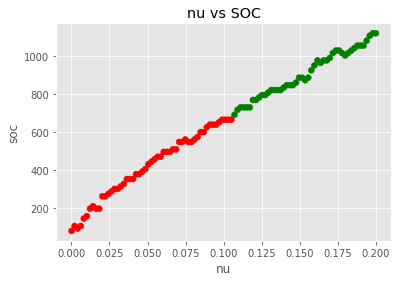

In [245]:
# # best SOC 880
# model=NuSVR(nu=0.10999,C=12.742749857031335, gamma = 0.11288378916846883,kernel='rbf')


nu_range = np.linspace(0.0001,0.2,100)
socs = []
mses = []
nus = []

for nu in nu_range:
    model = NuSVR(nu=nu,C=695.1927961775606, gamma = 0.05455594781168517, kernel='rbf')
    mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)

    std=np.std(mse)
    mse=np.abs(np.mean(mse))
    
    model.fit(X,y)
    socs.append(model.n_support_[0]*(3*k+3))
    mses.append(mse)
    nus.append(nu)

colors = []
for mse in mses:
    if mse > minRMSE * 1.1:
        colors.append('red')
    else:
        colors.append('green')
        
plt.title("nu vs SOC")
plt.scatter(nus,socs,c=colors)
plt.xlabel('nu')
plt.ylabel('soc')
plt.show()

In [248]:
mses=np.asarray(mses)
socs=np.asarray(socs)
mask=mses < minRMSE*1.1
print(mses[mask])
print(socs[mask])
print(nu_range[mask])

[2.00739437 2.00298079 2.00186554 1.99859693 1.99104144 1.98765625
 1.98673266 1.98387985 1.97888209 1.97137413 1.96699841 1.96203866
 1.95836221 1.95525831 1.95156234 1.94730789 1.94473031 1.94074308
 1.93795631 1.93755352 1.93437351 1.93207902 1.93222737 1.93074958
 1.92534287 1.92258297 1.91792605 1.9135134  1.91001232 1.90641823
 1.90046042 1.89785143 1.89758014 1.89551518 1.89448757 1.89188281
 1.88919957 1.88712424 1.88253744 1.88038917 1.88061748 1.88090563
 1.88110925 1.87993211 1.87811508 1.87716302 1.87582857]
[ 689  715  728  728  728  728  767  767  780  793  793  806  819  819
  819  819  832  845  845  845  858  884  884  871  884  923  949  975
  962  975  975  988 1014 1027 1027 1014 1001 1014 1027 1040 1053 1053
 1053 1079 1105 1118 1118]
[0.10711717 0.10913636 0.11115556 0.11317475 0.11519394 0.11721313
 0.11923232 0.12125152 0.12327071 0.1252899  0.12730909 0.12932828
 0.13134747 0.13336667 0.13538586 0.13740505 0.13942424 0.14144343
 0.14346263 0.14548182 0.14750101

In [147]:
533//(3*k+3)

41

Best Hyperparameters::
{'C': 0.1111111111111111, 'kernel': 'linear'}
SOC:  3240
MSE:  2.3315131657733943 STD:  0.24623200797288758


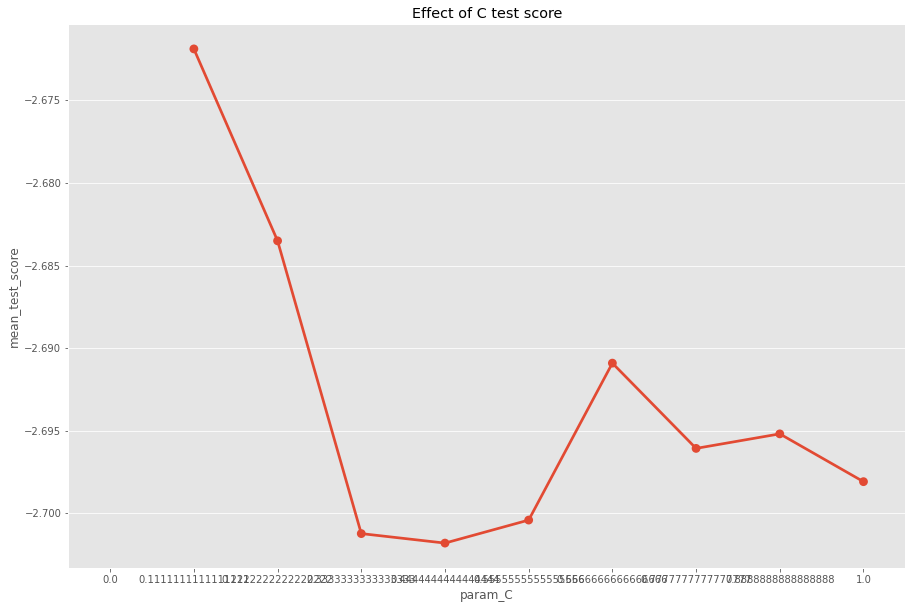

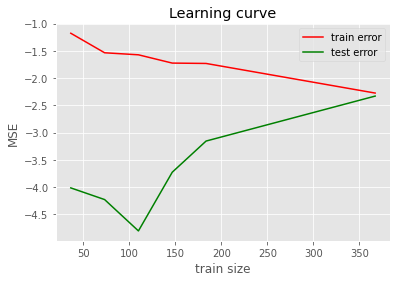

In [268]:
params = {'C':np.linspace(0,1,10),
          'kernel':['linear']}

gcv = GridSearchCV(SVR(),params,cv=5,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C']],
             y='mean_test_score',x='param_C')
ax.set(title="Effect of C test score")
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+1))

mse = cross_val_score(svr,X,y,cv=cv,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))

print("MSE: ",mse,"STD: ",std)

if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

Best Hyperparameters::
{'C': 100.0, 'gamma': 0.001, 'kernel': 'sigmoid'}
SOC:  4308
MSE:  2.3346410538689026 STD:  0.24743046127248666


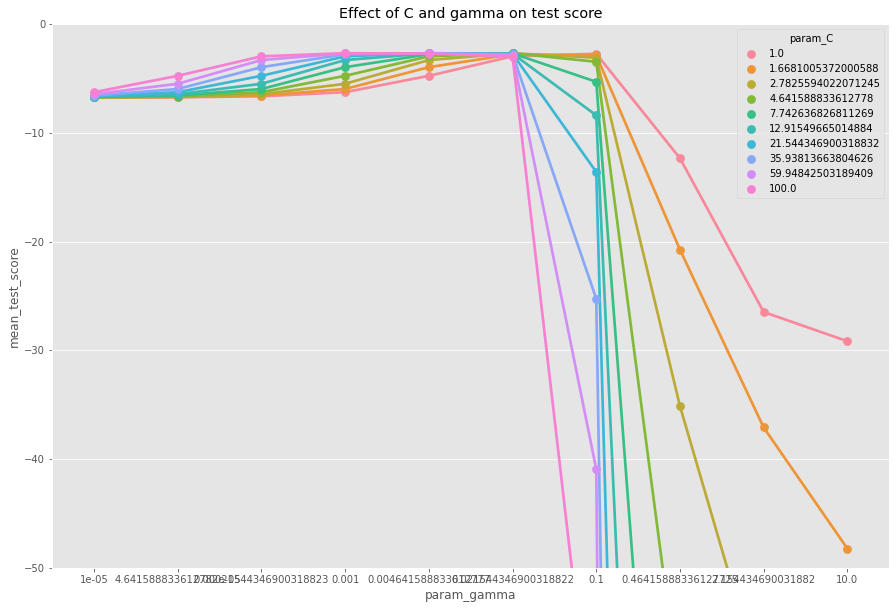

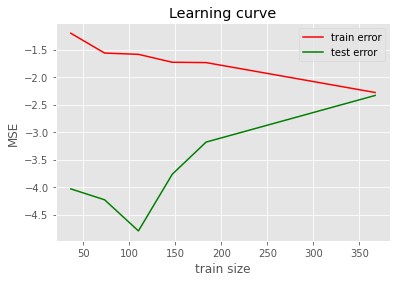

In [269]:
params = {'C':np.logspace(0,2,10),
          'gamma':np.logspace(-5,1,10),
          'kernel':['sigmoid',]}


gcv = GridSearchCV(SVR(),params,cv=5,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
ax.set_ylim([-50,0])
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+4))


mse = cross_val_score(svr,X,y,cv=cv,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))

print("MSE: ",mse,"STD: ",std)    

if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

Best Hyperparameters::
{'C': 0.1, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}
SOC:  4272
MSE:  2.627931137312216 STD:  0.29960417677880063


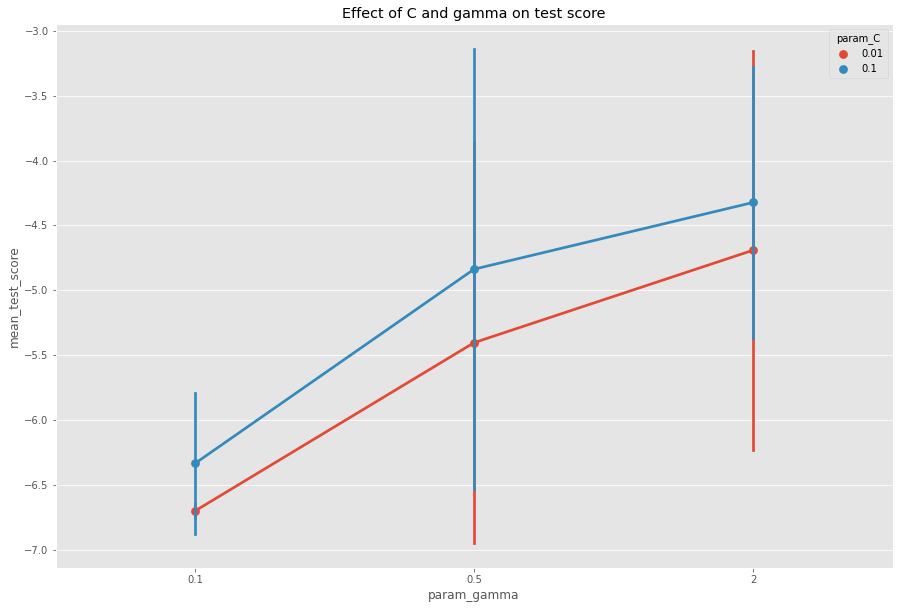

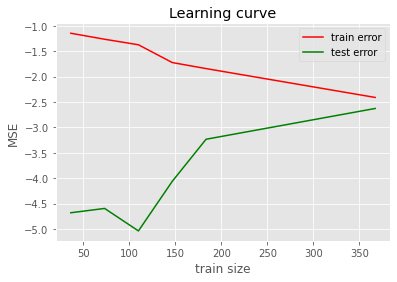

In [270]:
params = {'C':[0.01,0.1],
          'gamma':[0.1,0.5,2],
          'degree':[2,3],
          'kernel':['poly'],
         }


gcv = GridSearchCV(SVR(),params,cv=5,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+4))


mse = cross_val_score(svr,X,y,cv=cv,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))

print("MSE: ",mse,"STD: ",std)

if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

__,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

In [ ]:
soc=get_soc(model_selected.kernel,len(model_selected.support_vectors_),k)
print('Best Model: ',model_selected, 'kernel: ',model_selected.kernel)
print('SOC: ',soc)
print('MSE: ',minRMSE)

Best Model:  SVR(C=35.938136638046274, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.1, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False) kernel:  rbf
SOC:  5616
MSE:  6.383379962534403


In [ ]:
#SAVE MODEL IN GITHUB
import pickle

!git clone https://github.com/zhumakhan/IML.git
filename='./autompg+svr.model'

with open(filename, 'wb') as file:
    pickle.dump(model_selected,file)

!mv ./autompg+svr.model ./IML/autompg+svr.model
!cd IML && git add . && git commit -m'svr model update' && git push --force
!rm -rf ./IML
# some time later...
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

Cloning into 'IML'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 51 (delta 29), reused 51 (delta 29), pack-reused 0
Unpacking objects: 100% (51/51), done.

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@452cf6969059.(none)')
